# Problem Set 4

Yewon Kim 

In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

pts = np.loadtxt('usincmoms.txt')
# pts

# (a) Plot the histogram

In [2]:
pts

array([[  3.51901560e-02,   2.50000000e+03],
       [  4.10620640e-02,   7.50000000e+03],
       [  5.88594790e-02,   1.25000000e+04],
       [  5.68361070e-02,   1.75000000e+04],
       [  5.85952000e-02,   2.25000000e+04],
       [  5.44328360e-02,   2.75000000e+04],
       [  5.50604950e-02,   3.25000000e+04],
       [  5.06751460e-02,   3.75000000e+04],
       [  4.78589420e-02,   4.25000000e+04],
       [  4.08390800e-02,   4.75000000e+04],
       [  4.26972790e-02,   5.25000000e+04],
       [  3.50993100e-02,   5.75000000e+04],
       [  3.66023870e-02,   6.25000000e+04],
       [  3.16802250e-02,   6.75000000e+04],
       [  2.97807330e-02,   7.25000000e+04],
       [  2.85088990e-02,   7.75000000e+04],
       [  2.50732960e-02,   8.25000000e+04],
       [  2.11917250e-02,   8.75000000e+04],
       [  2.14229670e-02,   9.25000000e+04],
       [  1.85902470e-02,   9.75000000e+04],
       [  2.08696370e-02,   1.02500000e+05],
       [  1.46260890e-02,   1.07500000e+05],
       [  

In [3]:
hist_pts = pandas.DataFrame(pts)
hist_pts.columns = ['percentage', 'midpoint']
hist_pts['max'] = hist_pts['midpoint']+2500
hist_pts['min'] = hist_pts['midpoint']-2500
hist_pts.loc[40,'min'] = 200000
hist_pts.loc[40,'max'] = 250000
hist_pts.loc[41,'min'] = 250000
hist_pts.loc[41,'max'] = 350000
hist_pts['bin'] = (hist_pts['max'] - hist_pts['min'])/1000
hist_pts.loc[40,'percentage'] = hist_pts.loc[40,'percentage']/10
hist_pts.loc[41,'percentage'] = hist_pts.loc[41,'percentage']/20

In [4]:
hist_pts.tail()

,percentage,midpoint,max,min,bin
37,0.002998,187500.0,190000.0,185000.0,5.0
38,0.003138,192500.0,195000.0,190000.0,5.0
39,0.002577,197500.0,200000.0,195000.0,5.0
40,0.001897,225000.0,250000.0,200000.0,50.0
41,0.001160,300000.0,350000.0,250000.0,100.0


<IPython.core.display.Javascript object>


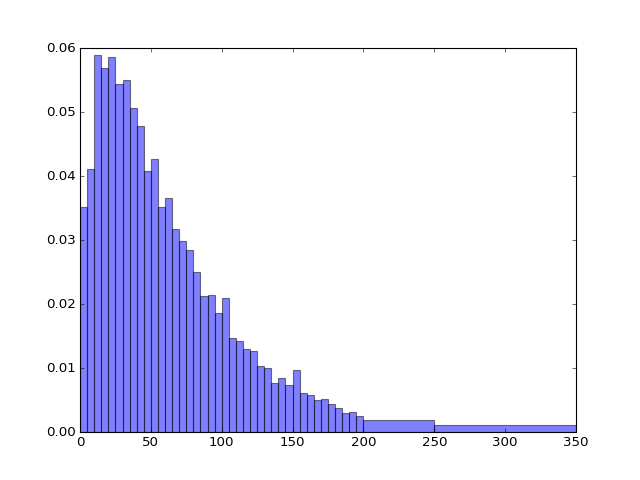

(0, 350)

In [6]:
%matplotlib notebook 
plt.bar(hist_pts['min']/1000, hist_pts['percentage'], hist_pts['bin'], alpha=0.5)
plt.xlim([0,350])

# (b) Fit the lognormal $LN(x; \mu, \sigma)$ distribution 

The pdf of lognormal distribution is the following:

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

Here, our data moments are just the second column of the usincmoms.txt data:

In [7]:
data_moments = pts[:,0]

In [8]:
def model_moments_lognormal(mu, sigma):
    cdf_lognorm = lambda x: sts.lognorm.cdf(x, scale = np.exp(mu), s = sigma)
    model_mm = []
    for a in np.arange(len(hist_pts)):
        model_mm.append(cdf_lognorm(hist_pts.loc[a,'max'])-cdf_lognorm(hist_pts.loc[a,'min']))
 
    model_mm[41] = 1-cdf_lognorm(hist_pts.loc[41,'min'])
    return model_mm


def err_vec_lognormal(data, mu, sigma, simple):
  
    data_mm = data 
    model_mm = model_moments_lognormal(mu, sigma)
    if simple:
        err_vec = model_mm - data_mm
    else:
        err_vec = (model_mm - data_mm) / data_mm
    
    return err_vec


def criterion_lognormal(params, *args):
    mu, sigma = params
    data, W = args
    err = err_vec_lognormal(data, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [9]:
av_income = (pts[:,0]*pts[:,1]).sum()
av_income
np.log(av_income)

11.115769874346629

In [10]:
mu_init = np.log(av_income)
sig_init = 10
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(pts[:,0])
gmm_args = (data_moments, W_hat)

minimizer_kwargs = dict(method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)),args = (gmm_args))
results_b = opt.basinhopping(criterion_lognormal, params_init, minimizer_kwargs = minimizer_kwargs)
results_b

#results_b = opt.minimize(criterion, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#results_b

                        fun: 0.045945282528343706
 lowest_optimization_result:       fun: 0.045945282528343706
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.22044605e-08,   1.17961196e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([ 10.76684406,   0.90784116])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2481
                        nit: 100
                          x: array([ 10.76684406,   0.90784116])

In [11]:
mu_GMM1, sig_GMM1 = results_b.x
print('---------- Lognormal distribution ----------')
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('minimized criterion function value =', results_b.fun)

---------- Lognormal distribution ----------
mu_GMM1= 10.7668440637  sig_GMM1= 0.907841163302
minimized criterion function value = 0.0459452825283


<IPython.core.display.Javascript object>


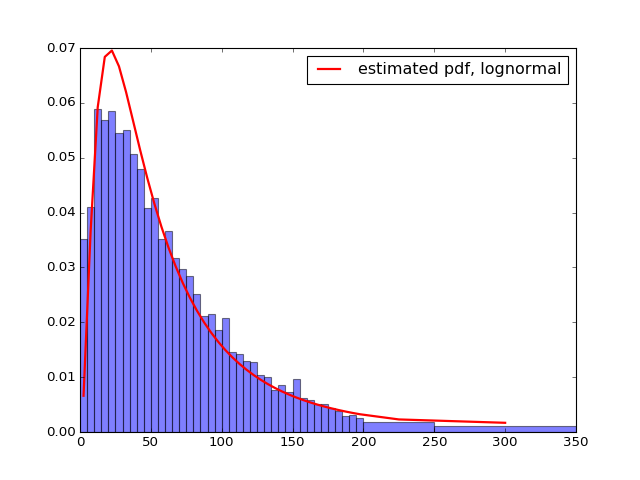

In [13]:
%matplotlib notebook 
plt.bar(hist_pts['min']/1000, hist_pts['percentage'], hist_pts['bin'], alpha=0.5)
plt.xlim([0,350])

mmm = model_moments_lognormal(mu_GMM1, sig_GMM1)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='r', label='estimated pdf, lognormal')
plt.legend(loc='upper right')

# (c) Fit the GA distribution

The pdf of GA distribution is the following: 

$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$


In [14]:
def model_moments_gamma(aa, bb):
    cdf_gamma = lambda x: sts.gamma.cdf(x, aa, loc=0, scale = bb)
    model_mm = []
    for a in np.arange(len(hist_pts)):
        model_mm.append(cdf_gamma(hist_pts.loc[a,'max'])-cdf_gamma(hist_pts.loc[a,'min']))
 
    model_mm[41] = 1-cdf_gamma(hist_pts.loc[41,'min'])
    return model_mm


def err_vec_gamma(data, mu, sigma, simple):
  
    data_mm = data 
    model_mm = model_moments_gamma(mu, sigma)
    if simple:
        err_vec = model_mm - data_mm
    else:
        err_vec = (model_mm - data_mm) / data_mm
    
    return err_vec

def criterion_gamma(params, *args):
    mu, sigma = params
    data, W = args
    err = err_vec_gamma(data, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [15]:
params_init = np.array([3,20000])
W_hat = np.diag(pts[:,0])
gmm_args = (data_moments, W_hat)

minimizer_kwargs = dict(method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)),args = (gmm_args))
results_c = opt.basinhopping(criterion_gamma, params_init, minimizer_kwargs = minimizer_kwargs)
results_c

                        fun: 0.012343065305478081
 lowest_optimization_result:       fun: 0.012343065305478081
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.04297731e-08,  -2.67147415e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 3
   status: 0
  success: True
        x: array([  1.36160004e+00,   4.83740016e+04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2178
                        nit: 100
                          x: array([  1.36160004e+00,   4.83740016e+04])

In [16]:
alpha_GMM, beta_GMM = results_c.x
print('------------ Gamma distribution ----------')
print('alpha_GMM=', alpha_GMM, ' beta_GMM=', beta_GMM)
print('minimized criterion function value =', results_c.fun)

------------ Gamma distribution ----------
alpha_GMM= 1.36160004107  beta_GMM= 48374.0015587
minimized criterion function value = 0.0123430653055


<IPython.core.display.Javascript object>


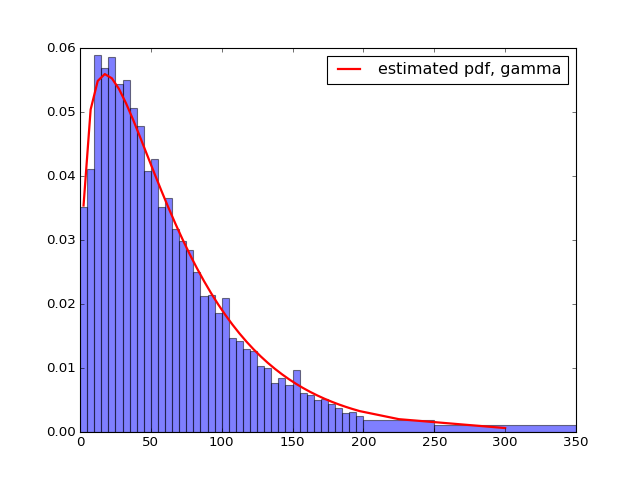

In [17]:
%matplotlib notebook 
plt.bar(hist_pts['min']/1000, hist_pts['percentage'], hist_pts['bin'], alpha=0.5)
plt.xlim([0,350])

mmm = model_moments_gamma(alpha_GMM, beta_GMM)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='r', label='estimated pdf, gamma')
plt.legend(loc='upper right')

# (d) Plot the histogram of data, fitted lognormal and fitted gamma

<IPython.core.display.Javascript object>


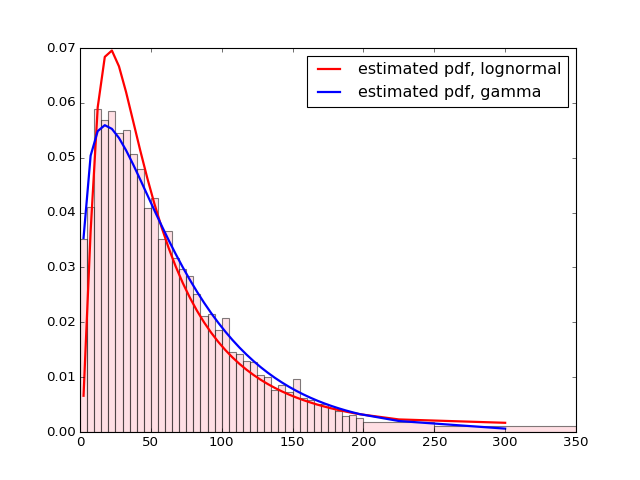

In [18]:
%matplotlib notebook 
plt.bar(hist_pts['min']/1000, hist_pts['percentage'], hist_pts['bin'], color='pink', alpha=0.5)
plt.xlim([0,350])


mmm = model_moments_lognormal(mu_GMM1, sig_GMM1)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='r', label='estimated pdf, lognormal')
plt.legend(loc='upper right')

mmm = model_moments_gamma(alpha_GMM, beta_GMM)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='b', label='estimated pdf, gamma')
plt.legend(loc='upper right')

According to the plot, gamma distribution seems to fit the data better. In this problem set, since we are using the same moments and weigithing matrix for both estimations (one using lognormal and one using gamma distribution), comparing the value of minimized criterion function might be one way to evaluate the goodness of fit. The minimized value also favors gamma distribution (GA: 0.012, LN: 0.046). 

If two models with different moments and/or differnet weighting matrix should be compared, one way to do so is to discretize the observed data into small bins and perform a chi-squared test for each bin. This might be a 'statistical' version of visual inspection of the histogram and the estimated pdf. 

# (e) Repeat (c) using two-step estimator for the optimal weighting matrix 

To calculate $\hat{W}_{twostep}$, I first calculate $\hat{\theta}_1$ given $W=I$, and update the weighting matrix as follows:

$$ \hat{W}^{two-step} \equiv \hat{\Omega}_2^{-1} $$

$$ \text{where } \hat{\Omega}_2 = \frac{1}{N}e(x|\hat{\theta}_{1,GMM})\,e(x|\hat{\theta}_{1,GMM})^T $$

In [19]:
params_init = np.array([3,20000])
W_hat = np.eye(42)
gmm_args = (data_moments, W_hat)

minimizer_kwargs = dict(method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)),args = (gmm_args))
results_1step = opt.basinhopping(criterion_gamma, params_init, minimizer_kwargs = minimizer_kwargs)

alpha_1step, beta_1step = results_1step.x
err1 = err_vec_gamma(pts[:,0], alpha_1step, beta_1step, False)
VCV2 = np.outer(err1, err1.T)/pts.shape[0]
print(VCV2)

[[  3.91328706e-05   2.64102880e-04  -3.24314739e-05 ...,   1.36244048e-04
   -6.14728009e-05  -5.39548259e-04]
 [  2.64102880e-04   1.78239752e-03  -2.18875987e-04 ...,   9.19494151e-04
   -4.14872294e-04  -3.64134415e-03]
 [ -3.24314739e-05  -2.18875987e-04   2.68776731e-05 ...,  -1.12912629e-04
    5.09457525e-05   4.47152101e-04]
 ..., 
 [  1.36244048e-04   9.19494151e-04  -1.12912629e-04 ...,   4.74343959e-04
   -2.14022205e-04  -1.87847807e-03]
 [ -6.14728009e-05  -4.14872294e-04   5.09457525e-05 ...,  -2.14022205e-04
    9.65660121e-05   8.47562221e-04]
 [ -5.39548259e-04  -3.64134415e-03   4.47152101e-04 ...,  -1.87847807e-03
    8.47562221e-04   7.43907409e-03]]


In [20]:
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[  0.15271839   1.03067742  -0.12656578 ...,   0.53170062  -0.23990131
   -2.10561962]
 [  1.03067742   6.95591382  -0.85417674 ...,   3.58838138  -1.61906415
  -14.21056515]
 [ -0.12656578  -0.85417674   0.10489174 ...,  -0.44064835   0.19881887
    1.74503804]
 ..., 
 [  0.53170062   3.58838138  -0.44064835 ...,   1.85115591  -0.83523457
   -7.33087396]
 [ -0.23990131  -1.61906415   0.19881887 ...,  -0.83523457   0.37685469
    3.30766269]
 [ -2.10561962 -14.21056515   1.74503804 ...,  -7.33087396   3.30766269
   29.0314353 ]]


In [21]:
results_1step

                        fun: 0.67231759704294214
 lowest_optimization_result:       fun: 0.67231759704294214
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.53050922e-06,  -2.83106871e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 4
   status: 0
  success: True
        x: array([  1.36772407e+00,   4.64805732e+04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1992
                        nit: 100
                          x: array([  1.36772407e+00,   4.64805732e+04])

I use the parameter estimates from the first step as the initial values for the second step estimation. 

In [22]:
params_init = np.array([alpha_1step, beta_1step])
gmm_args = (data_moments, W_hat2)

minimizer_kwargs = dict(method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)),args = (gmm_args))
results_e = opt.basinhopping(criterion_gamma, params_init, minimizer_kwargs = minimizer_kwargs)
results_e

                        fun: 41.999924045333429
 lowest_optimization_result:       fun: 41.999924045333429
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00019327])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 3
   status: 0
  success: True
        x: array([  1.36767318e+00,   4.64768638e+04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 2673
                        nit: 100
                          x: array([  1.36767318e+00,   4.64768638e+04])

In [23]:
alpha_GMM2, beta_GMM2 = results_e.x
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2)
print('minimized criterion function value =', results_e.fun)

alpha_GMM2= 1.36767318471  beta_GMM2= 46476.8638037
minimized criterion function value = 41.9999240453


<IPython.core.display.Javascript object>


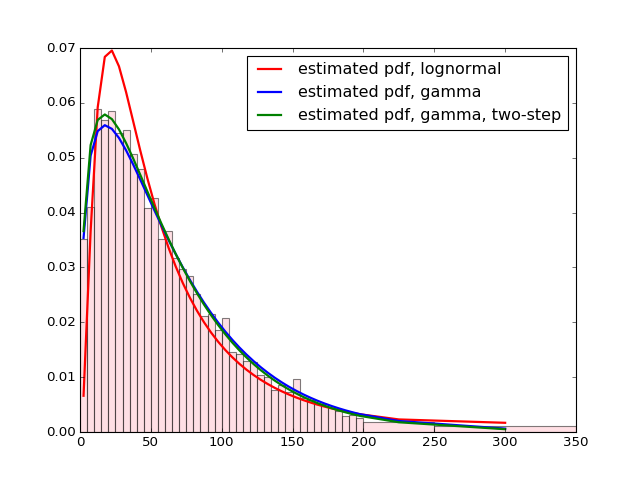

In [24]:
%matplotlib notebook 
plt.bar(hist_pts['min']/1000, hist_pts['percentage'], hist_pts['bin'], color='pink', alpha=0.5)
plt.xlim([0,350])


mmm = model_moments_lognormal(mu_GMM1, sig_GMM1)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='r', label='estimated pdf, lognormal')
plt.legend(loc='upper right')

mmm = model_moments_gamma(alpha_GMM, beta_GMM)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='b', label='estimated pdf, gamma')
plt.legend(loc='upper right')

mmm = model_moments_gamma(alpha_GMM2, beta_GMM2)
mmm[40] = mmm[40]/10
mmm[41] = mmm[41]/20
plt.plot(hist_pts['midpoint']/1000,mmm,
         linewidth=2, color='g', label='estimated pdf, gamma, two-step')
plt.legend(loc='upper right')

I calculate the difference between the two sets of parameters: 

In [25]:
print('Difference in alpha: ', np.abs(alpha_GMM2-alpha_GMM))
print('Difference in beta: ', np.abs(beta_GMM2-beta_GMM))

Difference in alpha:  0.00607314364181
Difference in beta:  1897.13775501


According to the plot, two-step estimates seem to show a small improvement in fitting the peak of the distribution. Note that the minimized value of the criterion function is no longer comparable to those from the previous esitimations because of the usage of different weighting matrix; in the two-step estimation, the minimized value is 41, whereas in the previous estimations, the value is much smaller than 1.  

Again, I can compare the goodness of fit by doing a chi-squared test for each bin. 